In [67]:
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custon style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

$\large{\text{Foundations of Kinematics and Algorithms in Robotics}} \\ \large{\text{Module 5: Graph Theory and Planning Algorithms}}$

$\text{By Jesse Haviland and Peter Corke}$

<br>

### Contents

[1.0 Graphs](#1)  
[2.0 Graph Search](#2)  

In [68]:
# We will do the imports required for this notebook here

# numpy provides import array and linear algebra utilities
import numpy as np
np.random.seed(0)

# the robotics toolbox provides robotics specific functionality
import roboticstoolbox as rtb

# spatial math provides objects for representing transformations
import spatialmath.base as smb

import pgraph as pg

<br>

<a id='1'></a>
# 1.0 Graphs
---

A graph is an abstract representation of a set of objects connected by links and depicted visually. Mathematically, a graph is denoted by $G(V, E)$ where $V$ are the vertices or nodes, and $E$ are the links that connect pairs of vertices and are called edges or arcs. Edges can be directed (shown as arrows) or undirected (shown as line segments). Edges can have a weight or cost associated with moving from one vertex to another. A sequence of edges from one vertex to another is a path, and a sequence that starts and ends at the same vertex is a cycle. An edge from a vertex to itself is a loop. Graphs can be used to represent transport, communications or social networks, and this branch of mathematics is graph theory.

We will illustrate graphs using the Python package `pgraph` that supports embedded graphs where the vertices are associated with a point in an n-dimensional space. To create a new graph

In [69]:
g = pg.UGraph()

and, by default, the vertices of the graph exist in 2-dimensional space. We can add ﬁve randomly-placed vertices to the graph

In [70]:
for i in range(5):
    g.add_vertex(np.random.rand(2))

The method add_vertex returns a reference to the newly created vertex object, but we can obtain the reference by indexing the graph object. For example vertex 1 is

In [71]:
g[1]

UVertex[#1, coord=(0.6028, 0.5449)]

and is an instance of UVertex, a vertex in an undirected graph; it has the coordinate $(0.6028; 0.5449)$; and has been assigned a default name `"#1"` but we could specify a different name. We can also reference a vertex by its name

In [72]:
g["#1"]

UVertex[#1, coord=(0.6028, 0.5449)]

We can create edges between pairs of vertex objects

In [73]:
g.add_edge(g[0], g[1])
g.add_edge(g[0], g[2])
g.add_edge(g[0], g[3])
g.add_edge(g[1], g[2])
g.add_edge(g[1], g[3])
g.add_edge(g[3], g[4])

Edge{[#3] -- [#4], cost=0.7315}

and the `add_edge` method returns a reference to the edge object just created. By default, the edge cost is the Euclidean distance between the vertices, but this can be overridden by a third argument to add_edge.

A summary of the graph can be displayed

In [74]:
print(g)

UGraph: 5 vertices, 6 edges, 1 component


This graph has one component, that is, all the vertices are connected into one network. The graph can be plotted by

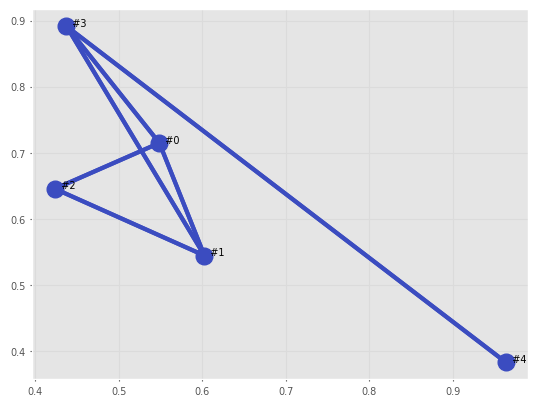

In [75]:
g.plot()

The vertices are shown as blue circles, and the edges are shown as lines joining vertices. Many options exist to change default plotting behaviour. Note that only graphs embedded in 2- and 3-dimensional space can be plotted.

The neighbors of vertex 1 are

In [76]:
g[1].adjacent()

[UVertex[#0, coord=(0.5488, 0.7152)],
 UVertex[#2, coord=(0.4237, 0.6459)],
 UVertex[#3, coord=(0.4376, 0.8918)]]

which is a list of neighbouring vertex objects, those connected to it by an edge. Each edge is an object and the edges connecting to vertex 1 are

In [77]:
g[1].edges()

[Edge{[#0] -- [#1], cost=0.1786},
 Edge{[#1] -- [#2], cost=0.2056},
 Edge{[#1] -- [#3], cost=0.3842}]

and each edge has references to the vertices it connects

In [78]:
g[1].edges()[0].endpoints

[UVertex[#0, coord=(0.5488, 0.7152)], UVertex[#1, coord=(0.6028, 0.5449)]]

The cost or length of an edge is

In [79]:
g[1].edges()[0].cost

0.1786470956951876

Arbitrary data can be attached to any vertex or edge by adding attributes to the vertex or edge objects, or by subclassing the UVertex and Edge classes.

The vertex closest to the coordinate (0.5, 0.5) is

In [80]:
g.closest((0.5, 0.5))

(UVertex[#1, coord=(0.6028, 0.5449)], 0.11213746732281339)

A tree is a specific type of graph with a tree-like hierarchical layout. Each node can have many child nodes but only one parent node. The root node is the only node that has no parent.

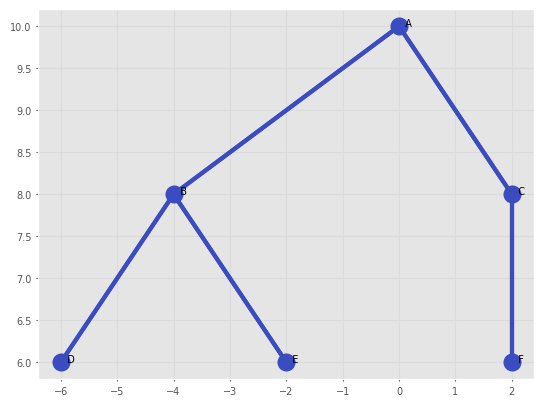

In [81]:
# Make a tree using PGraph

g = pg.UGraph()
g.add_vertex(name="A", coord=(0, 10))
g.add_vertex(name="B", coord=(-4, 8))
g.add_vertex(name="C", coord=(2, 8))
g.add_vertex(name="D", coord=(-6, 6))
g.add_vertex(name="E", coord=(-2, 6))
g.add_vertex(name="F", coord=(2, 6))

g.add_edge("A", "B")
g.add_edge("A", "C")
g.add_edge("B", "D")
g.add_edge("B", "E")
g.add_edge("C", "F")

g.plot()

Trees are far easier to deal with than a general graph as there are no cycles or closed-loops. There is also only one solution for how to get from the root node to any other node.

<br>

<a id='2'></a>
# 2.0 Tree Search
---

As searching through trees are much easier, we will start with searching through trees.

We will use the following tree for the following examples

In [82]:
ex_tree = pg.UGraph()
ex_tree.add_vertex(name="A")
ex_tree.add_vertex(name="B")
ex_tree.add_vertex(name="C")
ex_tree.add_vertex(name="D")
ex_tree.add_vertex(name="E")
ex_tree.add_vertex(name="F")
ex_tree.add_vertex(name="G")
ex_tree.add_vertex(name="H")
ex_tree.add_vertex(name="I")
ex_tree.add_vertex(name="J")

ex_tree.add_edge("A", "B")
ex_tree.add_edge("A", "C")
ex_tree.add_edge("B", "D")
ex_tree.add_edge("B", "E")
ex_tree.add_edge("C", "F")
ex_tree.add_edge("E", "G")
ex_tree.add_edge("E", "H")
ex_tree.add_edge("F", "I")
ex_tree.add_edge("F", "J")

print(ex_tree)

# You can use the showgraph method to generate a PDF of the graph
# tree.showgraph()

UGraph: 10 vertices, 9 edges, 1 component


<img src="Figures/5/tree.png" alt="dfs" style="width: 400px" />

## 2.1 Depth First Search

With depth-first search (DFS), we search down the tree until we reach a _leaf_ (where a leaf node is a node with no children). We then backtrack up the tree until we reach a node that has an unexplored child node. We then explore that child node and repeat the process.

A depth first traversal of the tree `ex_tree` would happen in the following order (assuming we visit the leftmost unvisited child first):

A -> B -> D -> E -> G -> H -> C -> F -> I -> J

Since a tree has no cycles, we do not need to keep a visited list or frontier list (which we will introduce later) and we can solve the search problem fairly easily using recursion.

We wish to find a path between A and J in the graph. We will use the following algorithm to do so:

On each recursion, we check if the current node is the goal node, if it is then we return the goal node and a signal that the goal was found. If it is not the goal node, we then check if the current node has any children. If it does, we then recursively call the function on each child node. If it does not, we return a signal that the goal was not found.

*Search 0*

Perform search on A  
A is not goal node  
A has two children  
Recursive search on B (Search 1)  
Recursive search on C (Search 6)  
Return A -> C -> F -> J and signal that goal was found  

*Search 1*

Perform search on B  
B is not goal node  
B has two children  
Recursive search on D (Search 2)  
Recursive search on E (Search 3)  
Return signal that goal was not found  

*Search 2*

Perform search on D  
D is not goal node  
D has no children  
Return signal that goal was not found  
  
*Search 3*  
  
Perform search on E (called from Search 1)  
E is not goal node  
E has two children  
Recursive search on G (Search 4)  
Recursive search on H (Search 5)  
Return signal that goal was not found  
  
*Search 4*  
  
Perform search on G  
G is not goal node  
G has no children  
Return signal that goal was not found  
  
*Search 5*  
  
Perform search on H (called from Search 3)  
H is not goal node  
H has no children  
Return signal that goal was not found  
  
*Search 6*  
  
Perform search on C (called from Search 0)  
C is not goal node  
C has one child  
Recursive search on F (Search 7)  
  
Return C -> F -> J and signal that goal was found  
  
*Search 7*  
  
Perform search on F  
F is not goal node  
F has two children  
Recursive search on I (Search 8)  
Recursive search on J (Search 9)  
  
Return F -> J and signal that goal was found  
  
*Search 8*  
  
Perform search on I  
I is not goal node  
I has no children  
Return signal that goal was not found  
  
*Search 9*  
  
Perform search on J (called from Search 7)  
J is goal node  
Return J and signal that goal was found  



After 10 recursive calls of our search function we have obtained the path A -> C -> F -> J.

## 2.2 Breadth First Search

With breadth first search (BFS), we search across the tree level by level. We start at the root node and search all of its children. We then search all of the children of those children and so on. We can think of this as searching the tree in a wave-like pattern.

A breadth first traversal of the tree `ex_tree` would happen in the following order:

A -> B -> C -> D -> E -> F -> G -> H -> I -> J

We keep a frontier list which is a first in - first out (fifo) queue and keeps track of where we need to go next. We will also keep track of the parent node that took us to the child node so we can reconstruct the path later. We will call this the parents list and store pairs (node, parent) in it.

We wish to find a path between A and J in the graph. We will use the following algorithm to do so:

On each loop, we take the first value from the frontier list. If it is not the goal node, we then check if the current node has any children. If it does, we then add each child to the frontier list. If it is the goal node, then we reconstruct the path by following from the goal node back to the root node using the parents list.

Initialise frontier with root node  
frontier = [A]  
parents = {A: None}  
  
*Iteration 0*  
  
Take first element from frontier list: A  
A is not goal node and has two children  
Add B and C to frontier list  
frontier = [B, C]  
parents = {A: None, B: A, C: A}  
  
*Iteration 1*  
  
Take first element from frontier list: B  
B is not goal node and has two children  
Add D and E to frontier list  
frontier = [C, D, E]  
parents = {A: None, B: A, C: A, D: B, E: B}  
  
*Iteration 2*  
  
Take first element from frontier list: C  
C is not goal node and has one child  
Add F to frontier list  
frontier = [D, E, F]  
parents = {A: None, B: A, C: A, D: B, E: B, F: C}  
  
*Iteration 3*  
  
Take first element from frontier list: D  
D is not goal node and has no children  
frontier = [E, F]  
parents = {A: None, B: A, C: A, D: B, E: B, F: C}  
  
*Iteration 4*  
  
Take first element from frontier list: E  
E is not goal node and has two children  
Add G and H to frontier list  
frontier = [F, G, H]  
parents = {A: None, B: A, C: A, D: B, E: B, F: C, G: E, H: E}  
  
*Iteration 5*  
  
Take first element from frontier list: F  
F is not goal node and has two children  
Add I and J to frontier list  
frontier = [G, H, I, J]  
parents = {A: None, B: A, C: A, D: B, E: B, F: C, G: E, H: E, I: F, J: F}  
  
*Iteration 6*  
  
Take first element from frontier list: G  
G is not goal node and has no children  
frontier = [H, I, J]  
parents = {A: None, B: A, C: A, D: B, E: B, F: C, G: E, H: E, I: F, J: F}  
  
*Iteration 7*  
  
Take first element from frontier list: H  
H is not goal node and has no children  
frontier = [I, J]  
parents = {A: None, B: A, C: A, D: B, E: B, F: C, G: E, H: E, I: F, J: F}  
  
*Iteration 8*  
  
Take first element from frontier list: I  
I is not goal node and has no children  
frontier = [J]  
parents = {A: None, B: A, C: A, D: B, E: B, F: C, G: E, H: E, I: F, J: F}  
  
*Iteration 9*  
  
Take first element from frontier list: J  
J is goal node  
  
Reconstruct the path by following the parent nodes back to the root node using the parents list  
J -> F  
F -> C  
C -> A  
  
The path is A -> C -> F -> J  
  


<br>

<a id='3'></a>
# 3.0 Graph Search
---

We have the following map of Queensland

<img src="./Figures/5/fig5_7.jpg" width="700">

For this example, we consider the towns and cities shown in the figure above, and we import a datafile included with the Toolbox

In [83]:
data = rtb.rtb_load_jsonfile("data/queensland.json")

where data is a dictionary containing two items. Firstly, `data["places"]` is a dictionary that maps place names to a dictionary of attributes such as latitude, longitude and UTM map coordinates in units of kilometres. We can easily plot these places, along with their names

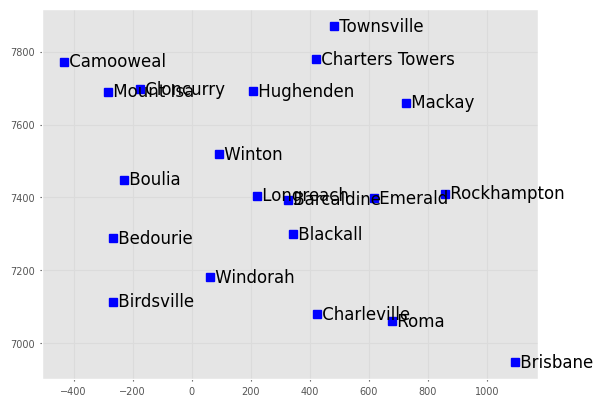

In [84]:
for name, info in data["places"].items():
    smb.plot_point(info["utm"], text=name)

Secondly, `data["routes"]` is a list of dictionaries that each define a graph edge: the name of its start and end place, the route length and the driving speed. For example

In [85]:
data["routes"][0]

{'start': 'Camooweal', 'end': 'Mount Isa', 'distance': 188, 'speed': 100}

We will use the Python `pgraph` package to create a graph representation of the data. The first step is to create an undirected graph object and then add vertices and edges from the data we just loaded

In [86]:
g = pg.UGraph()

for name, info in data["places"].items():
    g.add_vertex(name=name, coord=info["utm"])

for route in data["routes"]:
    g.add_edge(route["start"], route["end"], cost=route["distance"])


The `UGraph` object has many methods, for example, we can plot the graph we just created

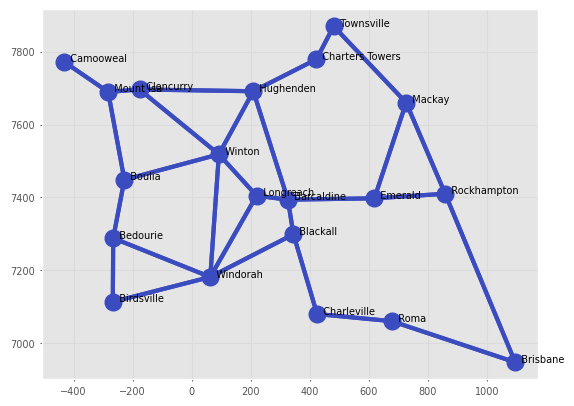

In [87]:
g.plot()

We can retrieve a vertex by its name

In [88]:
g["Brisbane"]

UVertex[Brisbane, coord=(1096, 6947)]

which is an object of UVertex class which represents a vertex in an undirected graph. Its neighbors, or adjacent vertices, are

In [89]:
g["Brisbane"].adjacent()

[UVertex[Rockhampton, coord=(858.9, 7410)], UVertex[Roma, coord=(677.7, 7060)]]

We can obtain references to the Edge objects that represent the edges. A list of the edges from the Brisbane vertex is given by

In [90]:
edges = g["Brisbane"].edges()
print(edges)

[Edge{[Rockhampton] -- [Brisbane], cost=682}, Edge{[Brisbane] -- [Roma], cost=482}]


and each edge has references to its endpoints

In [91]:
edges[0].endpoints

[UVertex[Rockhampton, coord=(858.9, 7410)],
 UVertex[Brisbane, coord=(1096, 6947)]]

Now, we are ready to plan a path, and will consider the specific example of a journey from Brisbane to Barcaldine. A simple-minded solution would be to randomly choose one of the neighbouring vertices, move there, and repeat the process. We might eventually reach our goal – but there is no guarantee of that – and it is extremely unlikely that the path would be optimal. A more systematic approach is required and we are fortunate this problem has been well-studied – it is the well-known graph search problem.

Starting at Brisbane, there are just two roads we can take to get to a neighbouring place. From one of those places, say Roma, we can visit in turn each of its neighbors. However, one of those neighbors is Brisbane, our starting point, and backtracking cannot lead to an optimal path. We need some means of keeping track of where we have been. The frontier (or open set) contains all the vertices that are scheduled for exploration, and the explored set (or closed set) contains all the vertices that we have explored and are finished with.

We will use BFS and then introduce two new algorithms and step through the solutions.

## 2.1 Breadth First Search

We will start at Brisbane and we want to travel to Barcaldine. With a graph instead of a tree, we will also keep a visited list to keep track of where we've already been. As we traverse through the graph, through the parents list, we are essentially constructing a tree from the graph where the root node is the staring node. Once we find the goal node, we can traverse back up through the tree to find the shortest path from the goal node to the starting node. At each iteration, we take the first node from the Frontier and add it to the Visited List.

Add brisbane to the frontier as our start node  
frontier = [Brisbane]  
visited = []  
parents = {Brisbane: None}  
  
**Iteration 0**:  
  
Move Brisbane to visited  
Add Brisbane's neighbouring nodes to frontier  
frontier = [Roma, Rockhampton]  
visited = [Brisbane]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane}  
  
**Iteration 1**:  
  
Move Roma to visited  
Add Roma's neighbouring nodes to the frontier (excluding those in visited)  
frontier = [Rockhampton, Charleville]  
visited = [Brisbane, Roma]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma}  
  
**Iteration 2**:  
  
Move Rockhampton to visited  
Add Rockhampton's neighbouring nodes to the frontier (excluding those in visited)  
frontier = [Charleville, Emerald, Mackay]  
visited = [Brisbane, Roma, Rockhampton]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton}  
  
**Iteration 3**:  
  
Move Charleville to visited  
Add Charleville's neighbouring nodes to the frontier (excluding those in visited)  
frontier = [Emerald, Mackay, Blackall]  
visited = [Brisbane, Roma, Rockhampton, Charleville]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton, Blackall:   Charleville}
  
**Iteration 4**:  
  
Move Emerald to visited  
Add Emerald's neighbouring nodes to the frontier (excluding those in visited)  
frontier = [Mackay, Blackall, Barcaldine]  
visited = [Brisbane, Roma, Rockhampton, Charleville, Emerald]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton, Blackall:   Charleville, Barcaldine: Emerald}
  
  
And we have found our goal node Barcaldine, so we stop. We can then use the parents list to find the path that led to the goal node:  
  
Brisbane -> Rockhampton -> Emerald -> Barcaldine

We can see that the path we found is the shortest in terms of nodes visited from Brisbane to Barcaldine. Other solutions exist with more nodes, such as the path:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine

While BFS will always find the shortest path in terms of total nodes in the path, it is not guaranteed to find the smallest path in terms of cost, or in this context, distance travelled.

## 2.2 Uniform Cost Search

A variation of BFS is uniform-cost-search (UCS). In BFS, we expanded vertices from the frontier on a first-in first-out basis, but now we will choose the frontier vertex that has the lowest cumulative distance from the start – the lowest cost to come.

We will start with Brisbane in the Frontier and in the brackets we will show the cumulative distance from the start node to this node.

Add brisbane to the frontier as our start node  
frontier = [Brisbane (0)]  
visited = []  
parents = {Brisbane: None}  

At each iteration, we take the vertex with the lowest cumulative distance from Brisbane from the Frontier and add it to the Visited List. We then add all the neighbours of that node to the Frontier. We repeat this process until we reach the goal node.



In [92]:
# Check Brisbane's edges
g["Brisbane"].edges()

[Edge{[Rockhampton] -- [Brisbane], cost=682},
 Edge{[Brisbane] -- [Roma], cost=482}]

**Iteration 0**:

Move Brisbane to visited  
Add Brisbane's neighbouring nodes to the frontier (and record the cumulative distance from the start node)  

frontier = [Roma (482), Rockhampton (682)]  
visited = [Brisbane]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane}  



**Iteration 1**:

We will expand Roma as it has the lowest cumulative distance from Brisbane

In [93]:
g["Roma"].edges()

[Edge{[Brisbane] -- [Roma], cost=482}, Edge{[Roma] -- [Charleville], cost=266}]

frontier = [Rockhampton (682), Charleville (482 + 266 = 748)]  
visited = [Brisbane (0), Roma (482)]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma}  

**Iteration 2**:

The next lowest cumulative distance is Rockhampton

In [94]:
g["Rockhampton"].edges()

[Edge{[Mackay] -- [Rockhampton], cost=334},
 Edge{[Rockhampton] -- [Brisbane], cost=682},
 Edge{[Rockhampton] -- [Emerald], cost=270}]

frontier = [Charleville (748), Emerald (682 + 270 = 952), Mackay (682 + 334 = 1016)]  
visited = [Brisbane (0), Roma (482), Rockhampton (682)]
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton}

**Iteration 3**:

The next lowest cumulative distance is Charleville

In [95]:
g["Charleville"].edges()

[Edge{[Roma] -- [Charleville], cost=266},
 Edge{[Charleville] -- [Blackall], cost=305}]

frontier = [Emerald (952), Mackay (1016), Blackall (748 + 305 = 1053)]  
visited = [Brisbane, Roma (482), Rockhampton (682), Charleville (748)]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton, Blackall: Charleville}

**Iteration 4**:

The next lowest cumulative distance is Emerald

In [96]:
g["Emerald"].edges()

[Edge{[Mackay] -- [Emerald], cost=384},
 Edge{[Rockhampton] -- [Emerald], cost=270},
 Edge{[Barcaldine] -- [Emerald], cost=307}]

frontier = [Mackay (1016), Blackall (1053), Barcaldine (952 + 307 = 1259), Mackay (952 + 384 = 1336), Rockhampthon (952 + 270 = 1222)]  
visited = [Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952)]  

_Remove the **new** Rockhampton and Mackay from frontier we already have paths to them with a lower cumulative distance_

frontier = [Mackay (1016), Blackall (1053), Barcaldine (1259)]  
visited = [Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952)]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton, Blackall: Charleville, Barcaldine: Emerald} 

With UCS, we may encounter places that are already on our frontier or visited lists. In this scenario, we will replace the existing node with the new node if the new node has a lower cumulative distance from Brisbane. Since the new routes to Mackay and Rockhampton are both longer than the existing routes, we will not replace them.

We have found our goal node Barcaldine, but we do not stop with UCS until all nodes are visited.

**Iteration 5**:

The next lowest cumulative distance is Mackay

In [97]:
g["Mackay"].edges()

[Edge{[Townsville] -- [Mackay], cost=388},
 Edge{[Mackay] -- [Rockhampton], cost=334},
 Edge{[Mackay] -- [Emerald], cost=384}]

frontier = [Blackall (1053), Barcaldine (1259), Townsville (1016 + 388 = 1404), Emerald (1016 + 384 = 1400)]  
visited = [Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016)]

Remove the new Emerald from frontier as it is already in visited with a lower cumulative distance.

frontier = [Blackall (1053), Barcaldine (1259), Townsville (1404)]  
visited = [Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016)]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton, Blackall: Charleville, Barcaldine: Emerald, Townsville: Mackay}

**Iteration 6**:

The next lowest cumulative distance is Blackall

In [98]:
g["Blackall"].edges()

[Edge{[Charleville] -- [Blackall], cost=305},
 Edge{[Blackall] -- [Barcaldine], cost=106},
 Edge{[Blackall] -- [Windorah], cost=530}]

frontier = [Barcaldine (1259), Townsville (1404), Windorah (1053 + 530 = 1583), Barcaldine (1053 + 106 = 1159)]  
visited = [Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016), Blackall (1053)]  

Remove the old Barcaldine from the frontier as the new route has a lower cumulative distance. We will also re-parent Barcaldine in the parents list to reflect this change

frontier = [Townsville (1404), Windorah (1583), Barcaldine (1159)]  
visited = [Brisbane, Roma (482), Rockhampton (682), Charleville (748), Emerald (952), Mackay (1016), Blackall (1053)]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Emerald: Rockhampton, Mackay: Rockhampton, Blackall: Charleville, Barcaldine: Blackall, Townsville: Mackay, Windorah: Blackall}

And our new best route to Barcaldine is:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine with a total cost of 1159

The UCS search will continue until all nodes in the graph has been visited. This can be expensive for very large graphs. This type of algorithm is known as a **brute force** algorithm. It is guaranteed to find the best solution, but it search the whole solution space to do so, which can be very computationally expensive.

Once we have finished the search, we use the parents list to reconstruct the path from goal node to the start node:

Barcaldine -> Blackall -> Charleville -> Roma -> Brisbane

which gives us the path from Brisbane to Barcaldine with the lowest cost:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine with a total cost of 1159

We can perform this search using `PGraph`

In [99]:
path, length, parents = g.path_UCS("Brisbane", "Barcaldine")
length

1159

In [100]:
", ".join([p.name for p in path])

'Brisbane, Roma, Charleville, Blackall, Barcaldine'

The parents list describes a tree rooted at the start node, with the shortest path to each node from the start node. We can plot this tree

In [101]:
tree = pg.DGraph.Dict(parents)
tree.showgraph()

<img src="./Figures/5/tree_2.png" width="400">

## 2.3 A* Search

A* is a variation on the UCS algorithm but we use a _heuristic_ to guide our path. A commonly used heuristic is the distance "as the crow flies" or Euclidean distance – easily computed since our graph is embedded and the position of every vertex is known.

To calculate the Euclidean distance between each node and Barcaldine, we simply loop through nodes in the graph

In [108]:
barcaldine_coords = g["Barcaldine"].coord

for name in sorted([n.name for n in g]):
    euc_dist = np.linalg.norm(barcaldine_coords - g[name].coord)
    print(f"{g[name].name}: {np.round(euc_dist)}")
    

Barcaldine: 0.0
Bedourie: 601.0
Birdsville: 656.0
Blackall: 97.0
Boulia: 557.0
Brisbane: 890.0
Camooweal: 847.0
Charleville: 329.0
Charters Towers: 398.0
Cloncurry: 587.0
Emerald: 293.0
Hughenden: 320.0
Longreach: 107.0
Mackay: 481.0
Mount Isa: 677.0
Rockhampton: 533.0
Roma: 485.0
Townsville: 501.0
Windorah: 338.0
Winton: 265.0


And we will use these numbers as our heuristic. The total cost we will use for each node is the cumulative distance from Brisbane plus the Euclidean distance to Barcaldine.

We start with Brisbane in the frontier list as our start node and in brackets we add the cumulative distance to the Heuristic value.

frontier = [Brisbane (0 + 890 = 890)]  
visited = []  
parents = {Brisbane: None}  

**Iteration 0**:

We move Brisbane to visited, and add Brisbane's neighbouring nodes to the frontier

frontier [Roma (485 + 482 = 967), Rockhampton (533 + 682 = 1215)]
visited = [Brisbane]
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane}

In [103]:
g["Brisbane"].edges()

[Edge{[Rockhampton] -- [Brisbane], cost=682},
 Edge{[Brisbane] -- [Roma], cost=482}]

**Iteration 1**:

We move Roma to visited, and add Roma's neighbouring nodes to the frontier

frontier = [Rockhampton (533 + 682 = 1215), Charleville (329 + 482 + 266 = 1077)]  
visited = [Brisbane, Roma (485 + 482 = 967)]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma}  

In [104]:
g["Roma"].edges()

[Edge{[Brisbane] -- [Roma], cost=482}, Edge{[Roma] -- [Charleville], cost=266}]

**Iteration 2**:

We move Charleville to visited, and add Charleville's neighbouring nodes to the frontier

frontier = [Rockhampton (533 + 682 = 1215), Blackall (97 + 482 + 266 + 305 = 1150)]  
visited = [Brisbane, Roma (485 + 482 = 967), Charleville (329 + 482 + 266 = 1077)]  
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Blackall: Charleville}  

In [105]:
g["Charleville"].edges()

[Edge{[Roma] -- [Charleville], cost=266},
 Edge{[Charleville] -- [Blackall], cost=305}]

**Iteration 3**:

We move Blackall to visited, and add Blackall's neighbouring nodes to the frontier

frontier = [Rockhampton (533 + 682 = 1215), Barcaldine (0 + 482 + 266 + 305 + 106 = 1159), Windorah (338 + 482 + 266 + 305 + 530 = 1921)]
visited = [Brisbane, Roma (485 + 482 = 967), Charleville (329 + 482 + 266 = 1077), Blackall (97 + 482 + 266 + 305 = 1150)]
parents = {Brisbane: None, Roma: Brisbane, Rockhampton: Brisbane, Charleville: Roma, Blackall: Charleville, Barcaldine: Blackall, Windorah: Blackall}

In [106]:
g["Blackall"].edges()

[Edge{[Charleville] -- [Blackall], cost=305},
 Edge{[Blackall] -- [Barcaldine], cost=106},
 Edge{[Blackall] -- [Windorah], cost=530}]

And we have found our goal node Barcaldine, so we stop.

We can then use the parents list to find the path that led to the goal node:

Brisbane -> Roma -> Charleville -> Blackall -> Barcaldine with a total cost of 1159 which is the lowest cost solution, and we found it in just 4 iterations (the same as BFS).

We can do this search using `PGraph`:

In [109]:
path, length, parents = g.path_Astar("Brisbane", "Barcaldine")
length

1159

In [110]:
", ".join([p.name for p in path])

'Brisbane, Roma, Charleville, Blackall, Barcaldine'

The performance of A* depends critically on the heuristic. A* is guaranteed to return the lowest-cost path only if the heuristic is admissible, that is, it does not overestimate the cost of reaching the goal. The Euclidean distance is an admissible heuristic since it is the minimum possible cost and by definition cannot be an overestimate. As the heuristic cost component increases from zero up to its maximum admissible value, the efficiency increases as fewer vertices are explored. A non-admissible heuristic may lead to a non-optimal path.